In [1]:
# Skip this cell if we are not on Google Colab
try:
    # Mount Google Drive to the Colab VM.
    from google.colab import drive
    drive.mount('/content/drive', force_remount=True)

    # Specify working directory.
    FOLDERNAME = 'cs231n/project/'
    %cd /content/drive/My\ Drive/$FOLDERNAME

    # Ensure that the Python interpreter of the Colab VM can load python files from
    # within it.
    import sys
    sys.path.append('/content/drive/My Drive/{}'.format(FOLDERNAME))
except ImportError as e:
    print("Not on Google Colab.")

Not on Google Colab.


## Load dataset and labels

In [2]:
import numpy as np
import os

#base_dir = '/content/drive/My Drive/cs231n/project/dataset/shaped_hrnet_data'
base_dir = '/home/ubuntu'

train_data = np.load(os.path.join(base_dir, 'train_data_pre60.npy'))
train_actions = np.load(os.path.join(base_dir, 'train_actions_pre60.npy'), allow_pickle=True)

val_data = np.load(os.path.join(base_dir, 'val_data_pre60.npy'))
val_actions = np.load(os.path.join(base_dir, 'val_actions_pre60.npy'), allow_pickle=True)

In [3]:
# reshape data
train_data = np.moveaxis(train_data, 2, -1)
val_data = np.moveaxis(val_data, 2, -1)

In [4]:
print('Training data shape: ', train_data.shape)
print('Training action shape: ', train_actions.shape)
print('Validation data shape: ', val_data.shape)
print('Validation action shape: ', val_actions.shape)

Training data shape:  (1007, 60, 64, 48, 17)
Training action shape:  (1007,)
Validation data shape:  (433, 60, 64, 48, 17)
Validation action shape:  (433,)


In [5]:
mapping = {
    'CALL': 0,
    'COUG': 1,
    'DRIN': 2,
    'SCRA': 3,
    'SNEE': 4,
    'STRE': 5,
    'WAVE': 6,
    'WIPE': 7,
}
train_action_labels = [mapping[x] for x in train_actions]
val_action_labels = [mapping[x] for x in val_actions]

# One-hot encoding.
train_action_labels = np.eye(8)[train_action_labels] 
val_action_labels = np.eye(8)[val_action_labels] 

<function matplotlib.pyplot.show(close=None, block=None)>

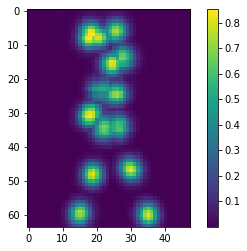

In [6]:
# make sure input dataset is correct
import matplotlib.pyplot as plt

plt.imshow(np.max(train_data[0,-1,:,:,:], axis=-1))
plt.colorbar()
plt.show

In [7]:
print(f"special value may be: {train_data[1,0,:,:,:].max(axis=-1)}")

special value may be: [[-10. -10. -10. ... -10. -10. -10.]
 [-10. -10. -10. ... -10. -10. -10.]
 [-10. -10. -10. ... -10. -10. -10.]
 ...
 [-10. -10. -10. ... -10. -10. -10.]
 [-10. -10. -10. ... -10. -10. -10.]
 [-10. -10. -10. ... -10. -10. -10.]]


In [8]:
train_data.shape

(1007, 60, 64, 48, 17)

## Model Structure: HR-Net + LSTM

In [9]:
from keras.layers import Input, TimeDistributed, Conv2D, Dense, MaxPooling2D, Flatten, LSTM, Dropout, BatchNormalization, Masking
from keras import models

# hr-net heatmap: (x, 60, 64, 48, 17)
timesteps = 60
rows, columns, channels = 64, 48, 17
special_value = -10.0

model = models.Sequential()
model.add(Input(shape=(timesteps, rows, columns, channels)))
model.add(TimeDistributed(Flatten()))
model.add(Dropout(0.2))

model.add(Masking(mask_value=special_value))
model.add(LSTM(16, return_sequences=False, dropout=0.2)) # used 16 units

#model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(8, activation='softmax')) # n_labels = 8
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed (TimeDistri (None, 60, 52224)         0         
_________________________________________________________________
dropout (Dropout)            (None, 60, 52224)         0         
_________________________________________________________________
masking (Masking)            (None, 60, 52224)         0         
_________________________________________________________________
lstm (LSTM)                  (None, 16)                3343424   
_________________________________________________________________
dense (Dense)                (None, 32)                544       
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 8)                 2

In [10]:
import keras
callbacks_list = [keras.callbacks.EarlyStopping(monitor='accuracy', patience=5),
                  keras.callbacks.ModelCheckpoint(
                      filepath='hrnet_lstm_model_v2',
                      monitor='val_loss',
                      save_best_only=True
                  ),
                  keras.callbacks.ReduceLROnPlateau(
                      monitor="val_loss", factor=0.1, patience=3
                  )]

from keras import optimizers

optimizer_new=optimizers.Adam(lr=1e-4, beta_1=0.9, beta_2=0.999, epsilon=None,
                              decay=0.0, amsgrad=False)
model.compile(optimizer=optimizer_new,
                    loss='categorical_crossentropy',
                    metrics=['accuracy'])

In [11]:
history = model.fit(train_data, train_action_labels,
                    validation_data=(val_data, val_action_labels),
                    batch_size=20, epochs=60,
                    callbacks=callbacks_list
                    )

Epoch 1/60
51/51 [==============================] - 28s 458ms/step - loss: 2.0816 - accuracy: 0.1504 - val_loss: 2.0637 - val_accuracy: 0.1755


INFO:tensorflow:Assets written to: hrnet_lstm_model_v2/assets


INFO:tensorflow:Assets written to: hrnet_lstm_model_v2/assets


Epoch 2/60
51/51 [==============================] - 12s 244ms/step - loss: 2.0194 - accuracy: 0.2279 - val_loss: 1.9863 - val_accuracy: 0.2263


INFO:tensorflow:Assets written to: hrnet_lstm_model_v2/assets


INFO:tensorflow:Assets written to: hrnet_lstm_model_v2/assets


Epoch 3/60
51/51 [==============================] - 12s 239ms/step - loss: 1.9461 - accuracy: 0.2775 - val_loss: 1.9157 - val_accuracy: 0.2725


INFO:tensorflow:Assets written to: hrnet_lstm_model_v2/assets


INFO:tensorflow:Assets written to: hrnet_lstm_model_v2/assets


Epoch 4/60
51/51 [==============================] - 12s 245ms/step - loss: 1.8665 - accuracy: 0.3250 - val_loss: 1.8735 - val_accuracy: 0.2956


INFO:tensorflow:Assets written to: hrnet_lstm_model_v2/assets


INFO:tensorflow:Assets written to: hrnet_lstm_model_v2/assets


Epoch 5/60
51/51 [==============================] - 12s 238ms/step - loss: 1.7887 - accuracy: 0.3764 - val_loss: 1.7975 - val_accuracy: 0.3418


INFO:tensorflow:Assets written to: hrnet_lstm_model_v2/assets


INFO:tensorflow:Assets written to: hrnet_lstm_model_v2/assets


Epoch 6/60
51/51 [==============================] - 12s 240ms/step - loss: 1.7132 - accuracy: 0.3967 - val_loss: 1.7394 - val_accuracy: 0.3510


INFO:tensorflow:Assets written to: hrnet_lstm_model_v2/assets


INFO:tensorflow:Assets written to: hrnet_lstm_model_v2/assets


Epoch 7/60
51/51 [==============================] - 12s 238ms/step - loss: 1.6366 - accuracy: 0.4392 - val_loss: 1.6949 - val_accuracy: 0.3880


INFO:tensorflow:Assets written to: hrnet_lstm_model_v2/assets


INFO:tensorflow:Assets written to: hrnet_lstm_model_v2/assets


Epoch 8/60
51/51 [==============================] - 12s 242ms/step - loss: 1.5701 - accuracy: 0.4879 - val_loss: 1.6306 - val_accuracy: 0.4088


INFO:tensorflow:Assets written to: hrnet_lstm_model_v2/assets


INFO:tensorflow:Assets written to: hrnet_lstm_model_v2/assets


Epoch 9/60
51/51 [==============================] - 12s 237ms/step - loss: 1.4918 - accuracy: 0.5376 - val_loss: 1.6041 - val_accuracy: 0.4527


INFO:tensorflow:Assets written to: hrnet_lstm_model_v2/assets


INFO:tensorflow:Assets written to: hrnet_lstm_model_v2/assets


Epoch 10/60
51/51 [==============================] - 12s 236ms/step - loss: 1.4502 - accuracy: 0.5414 - val_loss: 1.5513 - val_accuracy: 0.4988


INFO:tensorflow:Assets written to: hrnet_lstm_model_v2/assets


INFO:tensorflow:Assets written to: hrnet_lstm_model_v2/assets


Epoch 11/60
51/51 [==============================] - 12s 245ms/step - loss: 1.3944 - accuracy: 0.5733 - val_loss: 1.5056 - val_accuracy: 0.4711


INFO:tensorflow:Assets written to: hrnet_lstm_model_v2/assets


INFO:tensorflow:Assets written to: hrnet_lstm_model_v2/assets


Epoch 12/60
51/51 [==============================] - 13s 250ms/step - loss: 1.3294 - accuracy: 0.5766 - val_loss: 1.4718 - val_accuracy: 0.5150


INFO:tensorflow:Assets written to: hrnet_lstm_model_v2/assets


INFO:tensorflow:Assets written to: hrnet_lstm_model_v2/assets


Epoch 13/60
51/51 [==============================] - 12s 242ms/step - loss: 1.2485 - accuracy: 0.6370 - val_loss: 1.4457 - val_accuracy: 0.5196


INFO:tensorflow:Assets written to: hrnet_lstm_model_v2/assets


INFO:tensorflow:Assets written to: hrnet_lstm_model_v2/assets


Epoch 14/60
51/51 [==============================] - 12s 243ms/step - loss: 1.1946 - accuracy: 0.6398 - val_loss: 1.3798 - val_accuracy: 0.5289


INFO:tensorflow:Assets written to: hrnet_lstm_model_v2/assets


INFO:tensorflow:Assets written to: hrnet_lstm_model_v2/assets


Epoch 15/60
51/51 [==============================] - 12s 239ms/step - loss: 1.1912 - accuracy: 0.6601 - val_loss: 1.3926 - val_accuracy: 0.5427
Epoch 16/60
51/51 [==============================] - 12s 243ms/step - loss: 1.1322 - accuracy: 0.6601 - val_loss: 1.3656 - val_accuracy: 0.5612


INFO:tensorflow:Assets written to: hrnet_lstm_model_v2/assets


INFO:tensorflow:Assets written to: hrnet_lstm_model_v2/assets


Epoch 17/60
51/51 [==============================] - 12s 242ms/step - loss: 1.0729 - accuracy: 0.6807 - val_loss: 1.3110 - val_accuracy: 0.5774


INFO:tensorflow:Assets written to: hrnet_lstm_model_v2/assets


INFO:tensorflow:Assets written to: hrnet_lstm_model_v2/assets


Epoch 18/60
51/51 [==============================] - 12s 239ms/step - loss: 1.0005 - accuracy: 0.7581 - val_loss: 1.2778 - val_accuracy: 0.5982


INFO:tensorflow:Assets written to: hrnet_lstm_model_v2/assets


INFO:tensorflow:Assets written to: hrnet_lstm_model_v2/assets


Epoch 19/60
51/51 [==============================] - 12s 239ms/step - loss: 0.9728 - accuracy: 0.7460 - val_loss: 1.2301 - val_accuracy: 0.5866


INFO:tensorflow:Assets written to: hrnet_lstm_model_v2/assets


INFO:tensorflow:Assets written to: hrnet_lstm_model_v2/assets


Epoch 20/60
51/51 [==============================] - 12s 238ms/step - loss: 0.9064 - accuracy: 0.7580 - val_loss: 1.2069 - val_accuracy: 0.6120


INFO:tensorflow:Assets written to: hrnet_lstm_model_v2/assets


INFO:tensorflow:Assets written to: hrnet_lstm_model_v2/assets


Epoch 21/60
51/51 [==============================] - 12s 233ms/step - loss: 0.8589 - accuracy: 0.7818 - val_loss: 1.1950 - val_accuracy: 0.6236


INFO:tensorflow:Assets written to: hrnet_lstm_model_v2/assets


INFO:tensorflow:Assets written to: hrnet_lstm_model_v2/assets


Epoch 22/60
51/51 [==============================] - 12s 242ms/step - loss: 0.8347 - accuracy: 0.7887 - val_loss: 1.1300 - val_accuracy: 0.6467


INFO:tensorflow:Assets written to: hrnet_lstm_model_v2/assets


INFO:tensorflow:Assets written to: hrnet_lstm_model_v2/assets


Epoch 23/60
51/51 [==============================] - 12s 240ms/step - loss: 0.7938 - accuracy: 0.8114 - val_loss: 1.1562 - val_accuracy: 0.5935
Epoch 24/60
51/51 [==============================] - 12s 234ms/step - loss: 0.7898 - accuracy: 0.8082 - val_loss: 1.1712 - val_accuracy: 0.6212
Epoch 25/60
51/51 [==============================] - 12s 239ms/step - loss: 0.7595 - accuracy: 0.8210 - val_loss: 1.0976 - val_accuracy: 0.6374


INFO:tensorflow:Assets written to: hrnet_lstm_model_v2/assets


INFO:tensorflow:Assets written to: hrnet_lstm_model_v2/assets


Epoch 26/60
51/51 [==============================] - 12s 239ms/step - loss: 0.7242 - accuracy: 0.8318 - val_loss: 1.0851 - val_accuracy: 0.6467


INFO:tensorflow:Assets written to: hrnet_lstm_model_v2/assets


INFO:tensorflow:Assets written to: hrnet_lstm_model_v2/assets


Epoch 27/60
51/51 [==============================] - 12s 235ms/step - loss: 0.6502 - accuracy: 0.8575 - val_loss: 1.1003 - val_accuracy: 0.6443
Epoch 28/60
51/51 [==============================] - 12s 240ms/step - loss: 0.6549 - accuracy: 0.8647 - val_loss: 1.0716 - val_accuracy: 0.6490


INFO:tensorflow:Assets written to: hrnet_lstm_model_v2/assets


INFO:tensorflow:Assets written to: hrnet_lstm_model_v2/assets


Epoch 29/60
51/51 [==============================] - 12s 245ms/step - loss: 0.5927 - accuracy: 0.8614 - val_loss: 1.0689 - val_accuracy: 0.6467


INFO:tensorflow:Assets written to: hrnet_lstm_model_v2/assets


INFO:tensorflow:Assets written to: hrnet_lstm_model_v2/assets


Epoch 30/60
51/51 [==============================] - 13s 250ms/step - loss: 0.5925 - accuracy: 0.8930 - val_loss: 1.0503 - val_accuracy: 0.6628


INFO:tensorflow:Assets written to: hrnet_lstm_model_v2/assets


INFO:tensorflow:Assets written to: hrnet_lstm_model_v2/assets


Epoch 31/60
51/51 [==============================] - 13s 253ms/step - loss: 0.5823 - accuracy: 0.8692 - val_loss: 1.0559 - val_accuracy: 0.6420
Epoch 32/60
51/51 [==============================] - 13s 252ms/step - loss: 0.5523 - accuracy: 0.8717 - val_loss: 1.0704 - val_accuracy: 0.6282
Epoch 33/60
51/51 [==============================] - 13s 252ms/step - loss: 0.5406 - accuracy: 0.8805 - val_loss: 1.0578 - val_accuracy: 0.6467
Epoch 34/60
51/51 [==============================] - 13s 249ms/step - loss: 0.4741 - accuracy: 0.9039 - val_loss: 1.0252 - val_accuracy: 0.6490


INFO:tensorflow:Assets written to: hrnet_lstm_model_v2/assets


INFO:tensorflow:Assets written to: hrnet_lstm_model_v2/assets


Epoch 35/60
51/51 [==============================] - 13s 249ms/step - loss: 0.4598 - accuracy: 0.9229 - val_loss: 1.0236 - val_accuracy: 0.6490


INFO:tensorflow:Assets written to: hrnet_lstm_model_v2/assets


INFO:tensorflow:Assets written to: hrnet_lstm_model_v2/assets


Epoch 36/60
51/51 [==============================] - 12s 241ms/step - loss: 0.4690 - accuracy: 0.9266 - val_loss: 1.0292 - val_accuracy: 0.6467
Epoch 37/60
51/51 [==============================] - 12s 232ms/step - loss: 0.4351 - accuracy: 0.9218 - val_loss: 1.0265 - val_accuracy: 0.6490
Epoch 38/60
51/51 [==============================] - 12s 240ms/step - loss: 0.4591 - accuracy: 0.9004 - val_loss: 1.0229 - val_accuracy: 0.6536


INFO:tensorflow:Assets written to: hrnet_lstm_model_v2/assets


INFO:tensorflow:Assets written to: hrnet_lstm_model_v2/assets


Epoch 39/60
51/51 [==============================] - 12s 240ms/step - loss: 0.4282 - accuracy: 0.9352 - val_loss: 1.0230 - val_accuracy: 0.6559
Epoch 40/60
51/51 [==============================] - 12s 240ms/step - loss: 0.4166 - accuracy: 0.9345 - val_loss: 1.0211 - val_accuracy: 0.6674


INFO:tensorflow:Assets written to: hrnet_lstm_model_v2/assets


INFO:tensorflow:Assets written to: hrnet_lstm_model_v2/assets


Epoch 41/60
51/51 [==============================] - 13s 255ms/step - loss: 0.4324 - accuracy: 0.9428 - val_loss: 1.0256 - val_accuracy: 0.6582
Epoch 42/60
51/51 [==============================] - 13s 259ms/step - loss: 0.4373 - accuracy: 0.9342 - val_loss: 1.0247 - val_accuracy: 0.6582
Epoch 43/60
51/51 [==============================] - 15s 296ms/step - loss: 0.4342 - accuracy: 0.9299 - val_loss: 1.0233 - val_accuracy: 0.6559
Epoch 44/60
51/51 [==============================] - 16s 308ms/step - loss: 0.4506 - accuracy: 0.9236 - val_loss: 1.0225 - val_accuracy: 0.6559
Epoch 45/60
51/51 [==============================] - 20s 397ms/step - loss: 0.4034 - accuracy: 0.9479 - val_loss: 1.0236 - val_accuracy: 0.6559
Epoch 46/60
51/51 [==============================] - 21s 419ms/step - loss: 0.4110 - accuracy: 0.9386 - val_loss: 1.0239 - val_accuracy: 0.6559
Epoch 47/60
51/51 [==============================] - 19s 378ms/step - loss: 0.4510 - accuracy: 0.9345 - val_loss: 1.0238 - val_accuracy:

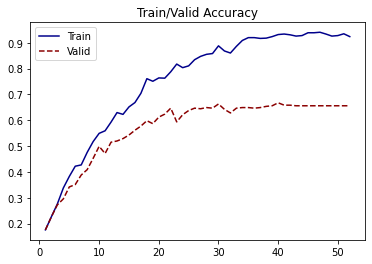

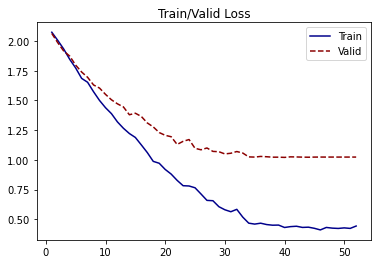

In [12]:
import matplotlib.pyplot as plt

acc=history.history["accuracy"]
val_acc=history.history["val_accuracy"]
loss=history.history["loss"]
val_loss=history.history["val_loss"]
epoch_stop = len(acc)
epochs=np.arange(1, epoch_stop+1)

plt.plot(epochs, acc, label = "Train", color = 'darkblue')
plt.plot(epochs, val_acc, label = "Valid", linestyle="--", color = 'darkred')
plt.legend()
plt.title('Train/Valid Accuracy')
plt.show()

plt.plot(epochs, loss, label = "Train", color = 'darkblue')
plt.plot(epochs, val_loss, label = "Valid", linestyle="--", color = 'darkred')
plt.legend()
plt.title('Train/Valid Loss')
plt.show()

## Evaluate model on test dataset

## Validation dataset

In [13]:
val_preds = model.predict_classes(val_data)

mapping = {
    'CALL': 0,
    'COUG': 1,
    'DRIN': 2,
    'SCRA': 3,
    'SNEE': 4,
    'STRE': 5,
    'WAVE': 6,
    'WIPE': 7,
}
val_true = [mapping[x] for x in val_actions]

/home/ubuntu/anaconda3/envs/tensorflow2_latest_p37/gpu_cuda11.0/lib/python3.7/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


<AxesSubplot:>

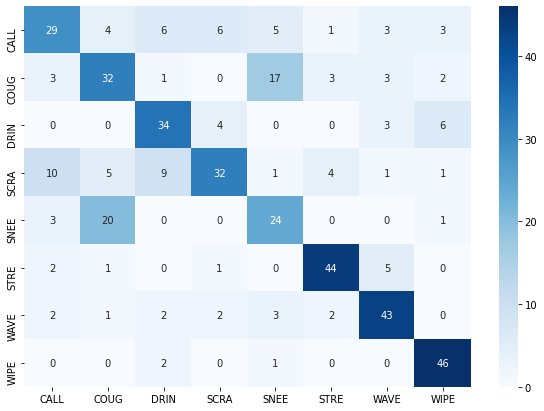

In [14]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
import sklearn.metrics as metrics

confusion_matrix = metrics.confusion_matrix(y_true=val_true, y_pred=val_preds)
df_cm = pd.DataFrame(confusion_matrix, index = mapping.keys(),
                  columns = mapping.keys())
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True, cmap="Blues")

In [15]:
# COUG:1, SNEE:4
val_true_bin = [x in (1, 4) for x in val_true]
val_preds_bin = [x in (1, 4) for x in val_preds]

<AxesSubplot:>

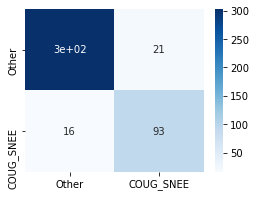

In [16]:
confusion_matrix = metrics.confusion_matrix(y_true=val_true_bin, y_pred=val_preds_bin)
df_cm = pd.DataFrame(confusion_matrix, index = ['Other', 'COUG_SNEE'],
                  columns = ['Other', 'COUG_SNEE'])
plt.figure(figsize = (4,3))
sn.heatmap(df_cm, annot=True, cmap="Blues")

In [17]:
tn, fp, fn, tp = confusion_matrix.ravel()
acc = tp / (tp+fp+fn)
acc

0.7153846153846154

## Test dataset

In [18]:
#base_dir = '/content/drive/My Drive/cs231n/project/dataset/shaped_hrnet_data'
base_dir = '/home/ubuntu'

test_data = np.load(os.path.join(base_dir, 'test_data_pre60.npy'))
test_actions = np.load(os.path.join(base_dir, 'test_actions_pre60.npy'), allow_pickle=True)

In [19]:
# reshape data
test_data = np.moveaxis(test_data, 2, -1)

In [25]:
print('Test data shape: ', test_data.shape)
print('Test action shape: ', test_actions.shape)

Test data shape:  (480, 60, 64, 48, 17)
Test action shape:  (480,)


In [20]:
test_preds = model.predict_classes(test_data)

mapping = {
    'CALL': 0,
    'COUG': 1,
    'DRIN': 2,
    'SCRA': 3,
    'SNEE': 4,
    'STRE': 5,
    'WAVE': 6,
    'WIPE': 7,
}
test_true = [mapping[x] for x in test_actions]

/home/ubuntu/anaconda3/envs/tensorflow2_latest_p37/gpu_cuda11.0/lib/python3.7/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


<AxesSubplot:>

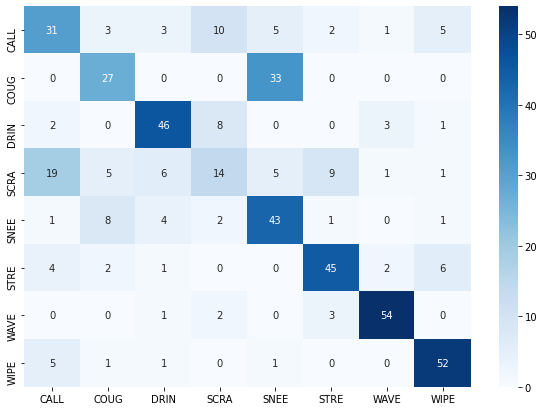

In [21]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
import sklearn.metrics as metrics

confusion_matrix = metrics.confusion_matrix(y_true=test_true, y_pred=test_preds)
df_cm = pd.DataFrame(confusion_matrix, index = mapping.keys(),
                  columns = mapping.keys())
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True, cmap="Blues")

In [22]:
# COUG:1, SNEE:4
test_true_bin = [x in (1, 4) for x in test_true]
test_preds_bin = [x in (1, 4) for x in test_preds]

<AxesSubplot:>

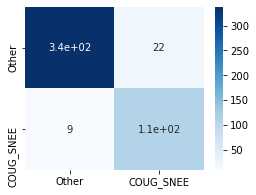

In [23]:
confusion_matrix = metrics.confusion_matrix(y_true=test_true_bin, y_pred=test_preds_bin)
df_cm = pd.DataFrame(confusion_matrix, index = ['Other', 'COUG_SNEE'],
                  columns = ['Other', 'COUG_SNEE'])
plt.figure(figsize = (4,3))
sn.heatmap(df_cm, annot=True, cmap="Blues")

In [24]:
tn, fp, fn, tp = confusion_matrix.ravel()
acc = tp / (tp+fp+fn)
acc

0.7816901408450704